In [20]:
import sys
import os
from dotenv import load_dotenv
import pandas as pd

# プロジェクトルートのパスを追加（quantechiaがあるディレクトリ）
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
load_dotenv()

True

In [ ]:
import pandas as pd
import numpy as np
from quantechia.strategy.basestrategy import basestrategy
from quantechia.strategy.trend import trend
from quantechia.strategy.risk import risk
from quantechia import analysis
from quantechia.data.data_fetcher import FinancialDataFetcher

from quantechia import utils
import importlib
importlib.reload(utils)
importlib.reload(basestrategy)
importlib.reload(trend)
importlib.reload(risk)
importlib.reload(analysis)

<module 'quantechia.analysis' from '/app/quantechia/analysis.py'>

In [22]:
# 株価データを取得
fetcher = FinancialDataFetcher()
tickers = ['AAPL', 'MSFT', 'GOOG']
start_date = '2023-01-01'
end_date = '2023-02-28'
historical_data = fetcher.get_historical_data("data_reader", name=tickers, data_source='stooq')
price_data = historical_data['Close']



In [23]:
equal_weight_strategy = basestrategy.EqualWeightStrategy(price_data, strategy_name="Equal Weight")
trend_following_strategy = trend.TrendFollowingStrategy(price_data, window=20, strategy_name="Trend Following")
risk_parity_strategy = risk.RiskParityStrategy(price_data, strategy_name="Risk Parity")
bl_strategy = risk.BlackLittermanStrategy(price_data, strategy_name="BL")
strategies = [equal_weight_strategy, trend_following_strategy, risk_parity_strategy,bl_strategy]


/usr/local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem doesn't have a solution with actual input parameters
Optimization failed at index 550: 'NoneType' object has no attribute 'values'
The problem doesn't have a solution with actual input parameters
Optimization failed at index 551: 'NoneType' object has no attribute 'values'


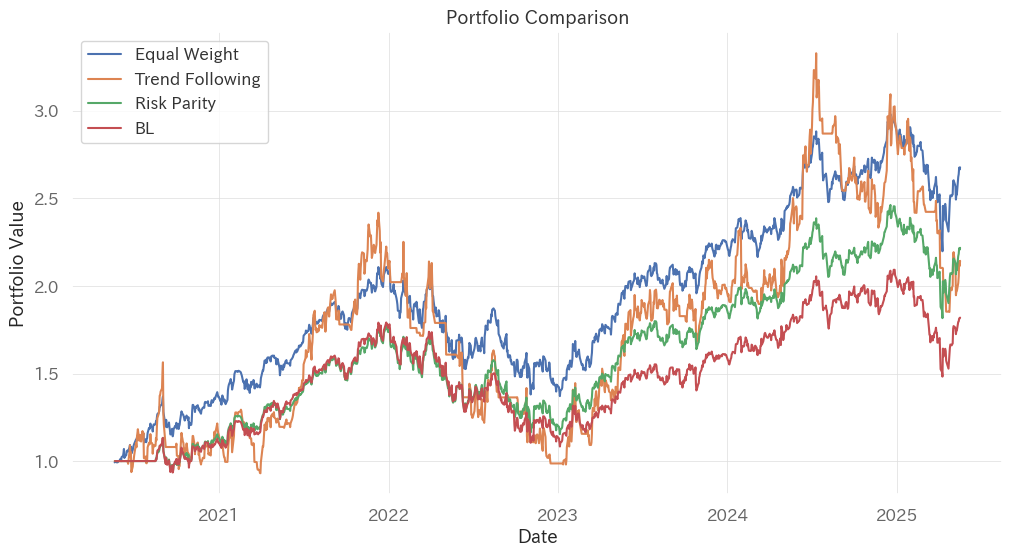

(                 sharpe_ratio  max_drawdown  winning_rate  turnover
 Equal Weight         0.898575     -0.349827      0.547049  0.000000
 Trend Following      0.562014     -0.594618      0.508325  7.098361
 Risk Parity          0.766516     -0.347954      0.542330  0.147087
 BL                   0.590449     -0.395432      0.532773  2.554874,
             Equal Weight  Trend Following  Risk Parity        BL
 Date                                                            
 2020-05-21     -0.007430         0.000000          NaN       NaN
 2020-05-22      0.004109         0.000000     0.000000  0.000000
 2020-05-26     -0.004244         0.000000     0.000000  0.000000
 2020-05-27      0.002097         0.000000     0.000000  0.000000
 2020-05-28     -0.000834         0.000000     0.000000  0.000000
 ...                  ...              ...          ...       ...
 2025-05-12      0.039813         0.023001     0.038300  0.027915
 2025-05-13      0.006031         0.018094     0.005654  0.0

In [24]:
analysis.compare_strategies(strategies)

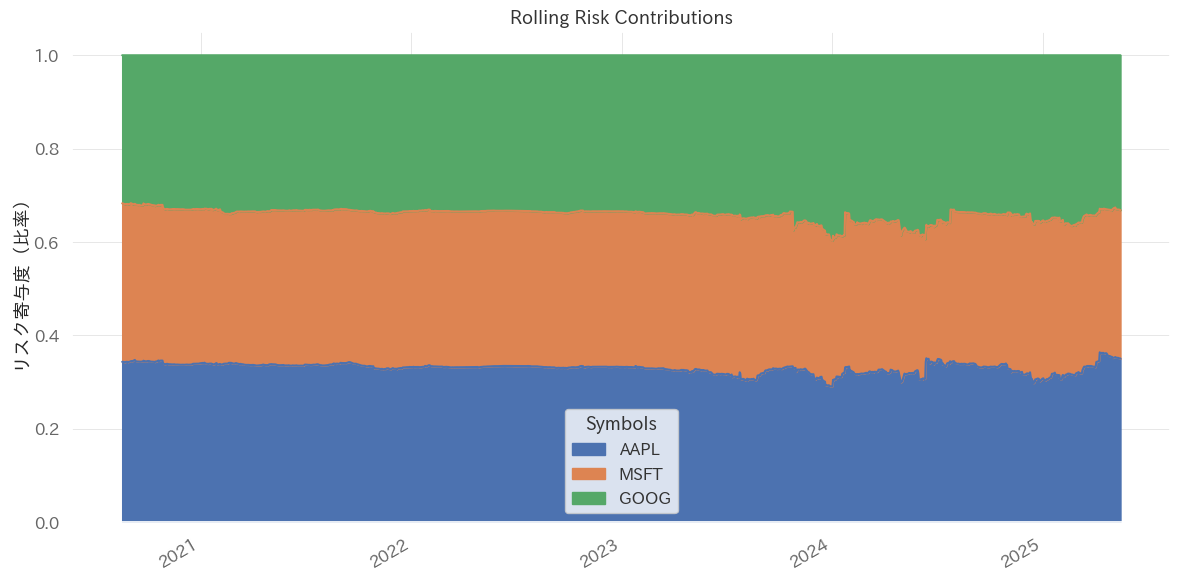

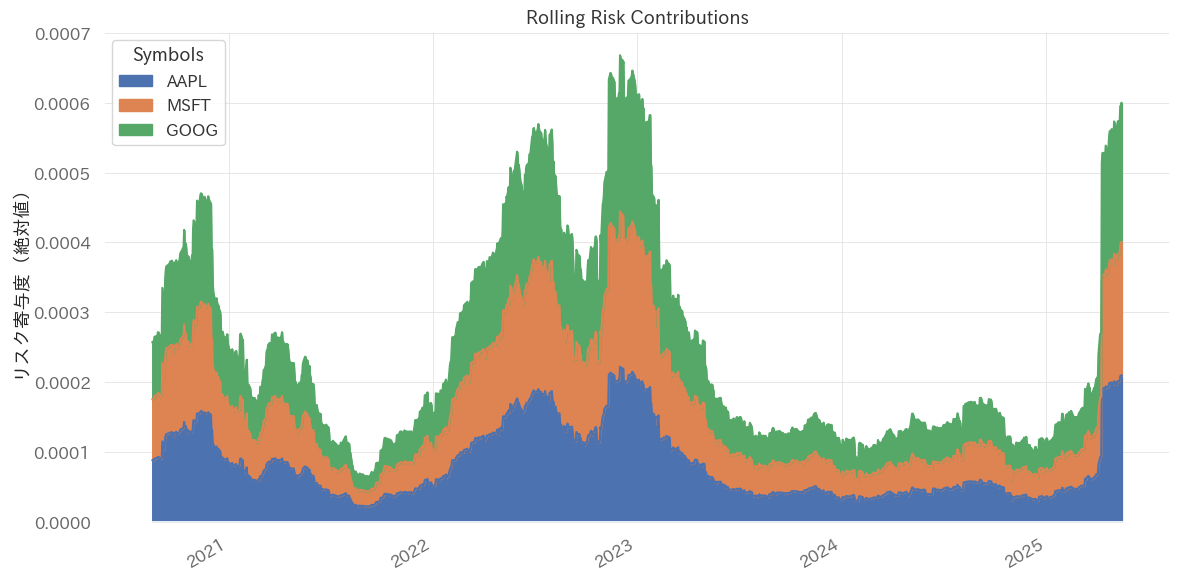

In [25]:
risk_parity_strategy.evaluate()
analyzer = analysis.RiskContribution(risk_parity_strategy.weight, risk_parity_strategy.rtn_data, lookback=60)
analyzer.calculate()

# データ取得
rc_df = analyzer.get_rc_dataframe()
rc_ratio_df = analyzer.get_ratio_dataframe()

# グラフ表示（比率）
analyzer.plot(ratio=True)
analyzer.plot(ratio=False)

In [26]:
import time
risk_parity_strategy = risk.RiskParityStrategy(price_data, strategy_name="Risk Parity")

start_time = time.time()
risk_parity_strategy.evaluate()
end_time = time.time()

elapsed = end_time - start_time
print(f"evaluate() 実行時間: {elapsed:.3f}秒")


KeyboardInterrupt: 

In [ ]:
import time
risk_parity_strategy2 = risk.RiskParityStrategyScipy(price_data, strategy_name="Risk Parity")

start_time = time.time()
risk_parity_strategy2.evaluate()
end_time = time.time()

elapsed = end_time - start_time
print(f"evaluate() 実行時間: {elapsed:.3f}秒")


evaluate() 実行時間: 8.137秒


In [ ]:
from quantechia.strategies.basestrategy import RebalanceStrategy 
# 使用例
rebalance_strategy = RebalanceStrategy(price_data, rebalance_freq='ME', lookback=60, strategy_name="Rebalance Strategy")
rebalance_strategy.evaluate()

{'sharpe_ratio': np.float64(-0.27397519580819835),
 'max_drawdown': np.float64(-0.10793778253304909),
 'winning_rate': 0.475,
 'turnover': np.float64(0.37041616375216485)}

In [ ]:
class RiskParityStrategyCustom(RebalanceStrategy):
    """
    A custom risk parity strategy that uses a custom optimizer for weight calculation.
    """

    def __init__(self, price_data: pd.DataFrame, rebalance_freq=None, lookback: int = 60, **kwargs):
        super().__init__(price_data, rebalance_freq=rebalance_freq, lookback=lookback, **kwargs)
    
    def calculate_current_weight(self, window_rtn):
        """
        Calculate weights using custom optimizer.
        """
        Sigma = (100*window_rtn).cov().values  # 共分散行列

        try:
            w_opt = risk.cal_risk_parity(Sigma)
        except Exception as e:
            print(f"Optimization failed at index {i}: {e}")
            w_opt = [np.nan] * len(window_rtn.columns)

        return w_opt
    
# 使用例
risk_parity_strategy_custom = RiskParityStrategyCustom(price_data, lookback=60, strategy_name="Risk Parity Custom")
risk_parity_strategy_custom.evaluate()

{'sharpe_ratio': np.float64(0.766245693131346),
 'max_drawdown': np.float64(-0.34786492660850143),
 'winning_rate': 0.5414920368818106,
 'turnover': np.float64(0.17739513239773028)}

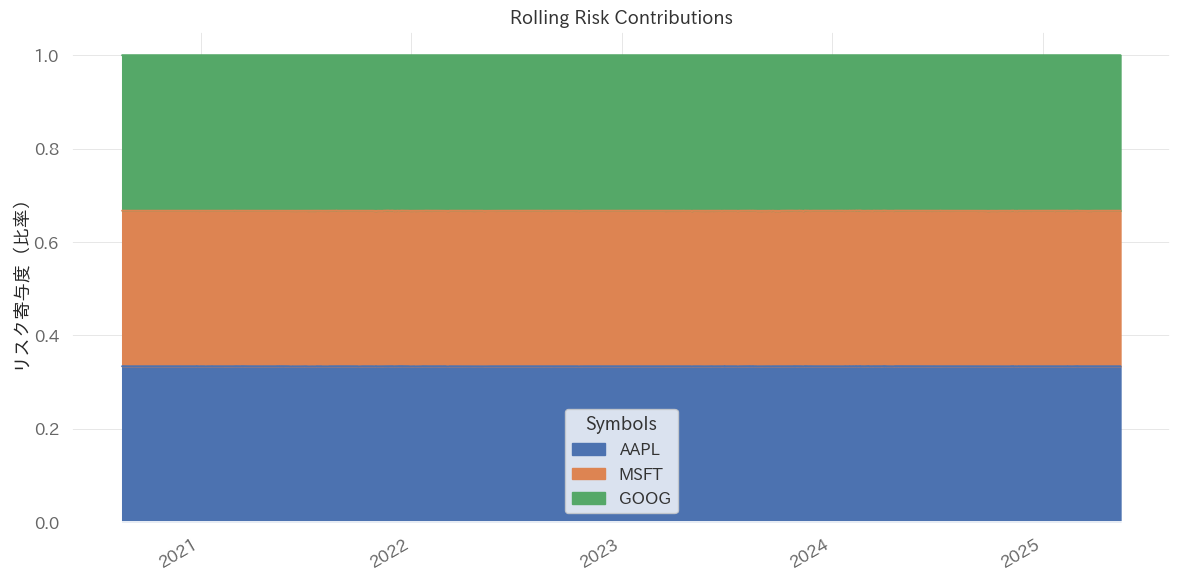

In [42]:
analyzer = analysis.RiskContribution(risk_parity_strategy_custom.weight, risk_parity_strategy_custom.rtn_data, lookback=60)
analyzer.calculate()
# データ取得
rc_df = analyzer.get_rc_dataframe()
rc_ratio_df = analyzer.get_ratio_dataframe()
# グラフ表示（比率）
analyzer.plot(ratio=True)


In [43]:
import pandas as pd
import numpy as np
import riskfolio as rp
from abc import ABC

class FactorConstrainedStrategy(BaseRiskfolioStrategy):
    """
    ファクター制約付き最適化を行うRiskfolio-Libベースの戦略クラス
    """

    def __init__(self, price_data: pd.DataFrame, factor_data: pd.DataFrame, lookback: int = 60,
                 optimizer: str = 'optimization', strategy_name: str = "Factor Constrained Strategy",
                 opt_params: dict = None, factor_constraints: pd.DataFrame = None, 
                 stepwise: str = 'Forward', **kwargs):
        """
        パラメータ:
        ----------
        price_data : pd.DataFrame
            資産価格のデータフレーム
        factor_data : pd.DataFrame
            ファクターのデータフレーム
        lookback : int, optional
            ルックバック期間, デフォルトは60
        optimizer : str, optional
            最適化手法, デフォルトは'optimization'
        strategy_name : str, optional
            戦略名, デフォルトは"Factor Constrained Strategy"
        opt_params : dict, optional
            最適化パラメータ, デフォルトはNone
        factor_constraints : pd.DataFrame, optional
            ファクター制約のデータフレーム, デフォルトはNone
        stepwise : str, optional
            ローディング行列計算のステップワイズ法, デフォルトは'Forward'
        """
        super().__init__(price_data, lookback=lookback, optimizer=optimizer, 
                         strategy_name=strategy_name, opt_params=opt_params, **kwargs)
        self.factor_data = factor_data
        self.factor_constraints = factor_constraints
        self.stepwise = stepwise
        self.loadings_matrix = None
        self.model = opt_params.get('model', 'FM')  # デフォルトはファクターモデル
        
    def _calculate_loadings_matrix(self, window_rtn: pd.DataFrame, window_factors: pd.DataFrame):
        """
        ファクターローディング行列を計算

        パラメータ:
        ----------
        window_rtn : pd.DataFrame
            資産リターンのウィンドウ
        window_factors : pd.DataFrame
            ファクターリターンのウィンドウ

        戻り値:
        -------
        pd.DataFrame
            ローディング行列
        """
        # ステップワイズ回帰を使用してローディング行列を計算
        try:
            loadings = rp.loadings_matrix(X=window_factors, Y=window_rtn, stepwise=self.stepwise)
            return loadings
        except Exception as e:
            print(f"ローディング行列の計算に失敗しました: {e}")
            # バックアップとして単純な相関行列を返す
            return window_factors.corrwith(window_rtn).to_frame().T
    
    def _prepare_factor_constraints(self, loadings):
        """
        ファクター制約を準備

        パラメータ:
        ----------
        loadings : pd.DataFrame
            ローディング行列

        戻り値:
        -------
        tuple
            (C, D) - 制約行列と制約ベクトル
        """
        if self.factor_constraints is None:
            return None, None
        
        try:
            C, D = rp.factors_constraints(self.factor_constraints, loadings)
            return C, D
        except Exception as e:
            print(f"ファクター制約の準備に失敗しました: {e}")
            return None, None
    
    def _update_opt_params(self, opt_params: dict, port: rp.Portfolio) -> dict:
        """
        最適化パラメータを更新

        パラメータ:
        ----------
        opt_params : dict
            最適化パラメータ
        port : rp.Portfolio
            ポートフォリオオブジェクト

        戻り値:
        -------
        dict
            更新された最適化パラメータ
        """
        opt_params = super()._update_opt_params(opt_params, port)
        
        # ファクターモデルを使用する場合、optimize_paramsにmodelを追加
        if 'optimize_params' in opt_params and self.model == 'FM':
            opt_params['optimize_params']['model'] = 'FM'
        
        return opt_params
    
    def _optimize_weights(self, window_rtn: pd.DataFrame) -> np.ndarray:
        """
        ファクター制約付き最適化を実行

        パラメータ:
        ----------
        window_rtn : pd.DataFrame
            資産リターンのウィンドウ

        戻り値:
        -------
        np.ndarray
            最適化されたウェイト
        """
        # 同じ期間のファクターデータを取得
        window_factors = self.factor_data.loc[window_rtn.index]
        
        # NaNを削除
        window_rtn = window_rtn.dropna()
        window_factors = window_factors.dropna()
        
        # 共通のインデックスのみを使用
        common_idx = window_rtn.index.intersection(window_factors.index)
        window_rtn = window_rtn.loc[common_idx]
        window_factors = window_factors.loc[common_idx]
        
        if len(window_rtn) < 10:  # 最小サンプル数のチェック
            print(f"警告: サンプル数が少なすぎます ({len(window_rtn)})")
            return np.array([np.nan] * len(window_rtn.columns))
        
        # ファクターローディング行列を計算
        self.loadings_matrix = self._calculate_loadings_matrix(window_rtn, window_factors)
        
        # 最適化パラメータを生成
        opt_params = self._generate_opt_params(window_rtn)
        
        # Portfolio生成時に必要な引数
        portfolio_args = self.opt_params.get('portfolio_args', {})
        port = self._create_portfolio(window_rtn, portfolio_args=portfolio_args)
        
        # ファクターを設定
        port.factors = window_factors
        
        # 前処理を適用
        preprocessing_params = opt_params.get('preprocessing_params', {})
        self._apply_preprocessing(port, preprocessing_params)
        
        # ファクター統計情報を計算
        method_mu = opt_params.get('method_mu', 'hist')
        method_cov = opt_params.get('method_cov', 'hist')
        port.factors_stats(method_mu=method_mu, method_cov=method_cov)
        
        # ファクター制約を設定
        if self.factor_constraints is not None:
            C, D = self._prepare_factor_constraints(self.loadings_matrix)
            if C is not None and D is not None:
                port.ainequality = C
                port.binequality = D
        
        # 最適化パラメータを更新
        opt_params = self._update_opt_params(opt_params, port)
        
        # 最適化用パラメータ
        optimize_params = opt_params.get('optimize_params', {})
        
        # モデルパラメータを設定（ファクターモデルを使用）
        if self.model == 'FM':
            optimize_params['model'] = 'FM'
        
        # 最適化実行
        if self.optimizer == 'rp':
            w = port.rp_optimization(**optimize_params)
        elif self.optimizer == 'rrp':
            w = port.rrp_optimization(**optimize_params)
        elif self.optimizer == 'wc':
            w = port.wc_optimization(**optimize_params)
        elif self.optimizer == 'frc':
            w = port.frc_optimization(**optimize_params)
        else:
            optimize_params['obj'] = opt_params.get('obj', 'Sharpe')
            w = port.optimization(**optimize_params)
        
        return w.values.flatten()
    
    def calculate_weight(self) -> pd.DataFrame:
        """
        ウェイトを計算

        戻り値:
        -------
        pd.DataFrame
            計算されたウェイト
        """
        # ファクターデータと資産データのインデックス一致を確認
        common_idx = self.rtn_data.index.intersection(self.factor_data.index)
        if len(common_idx) < len(self.rtn_data):
            print(f"警告: ファクターデータと資産データのインデックスが完全に一致していません。共通: {len(common_idx)}, 資産: {len(self.rtn_data)}")
        
        return super().calculate_weight()
    
    def get_loadings_matrix(self):
        """
        最新のローディング行列を取得

        戻り値:
        -------
        pd.DataFrame
            ローディング行列
        """
        return self.loadings_matrix
    
    def set_factor_constraints(self, constraints: pd.DataFrame):
        """
        ファクター制約を設定

        パラメータ:
        ----------
        constraints : pd.DataFrame
            制約のデータフレーム
            {'Disabled': [bool], 'Factor': [str], 'Sign': [str], 
             'Value': [float], 'Relative Factor': [str]}
            フォーマットでなければならない
        """
        required_columns = ['Disabled', 'Factor', 'Sign', 'Value', 'Relative Factor']
        if not all(col in constraints.columns for col in required_columns):
            raise ValueError(f"制約データフレームには次の列が必要です: {required_columns}")
        
        self.factor_constraints = constraints

データ取得中...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  23 of 23 completed
/tmp/ipykernel_94505/1311939089.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')



ローディング行列を計算中...

ローディング行列:
         const      MTUM      QUAL      VLUE      SIZE      USMV
AAPL  0.000198  0.233565  1.629983  0.000000 -0.718672  0.000000
MSFT  0.000392  0.109596  2.092606 -0.576180 -0.444326 -0.196852
AMZN -0.000372  0.000000  2.142399 -0.997459  0.824537 -1.044999
GOOG  0.000256  0.000000  2.463417 -0.405369 -0.337260 -0.834154
META -0.000009 -0.247638  3.702316 -0.759241  0.000000 -1.820508
TSLA  0.000472  1.224165  1.010720 -1.128429  2.137307 -2.335916
NVDA  0.001513  0.456739  4.311727 -0.886367  0.000000 -2.881690
JPM   0.000278  0.000000 -0.191522  1.134602  0.000000  0.000000
V    -0.000033  0.000000  0.699388  0.000000  0.000000  0.311382
PG   -0.000053 -0.170589  0.000000  0.209023 -0.712028  1.625659
JNJ  -0.000081 -0.151004  0.000000  0.341698 -0.758138  1.336458
UNH   0.000477  0.184881 -0.280783  0.324990 -0.762306  1.582708
HD    0.000099 -0.262645  0.564132  0.000000  0.332746  0.417643
BAC   0.000053  0.000000 -0.679440  1.310114  0.700879 -0.3363

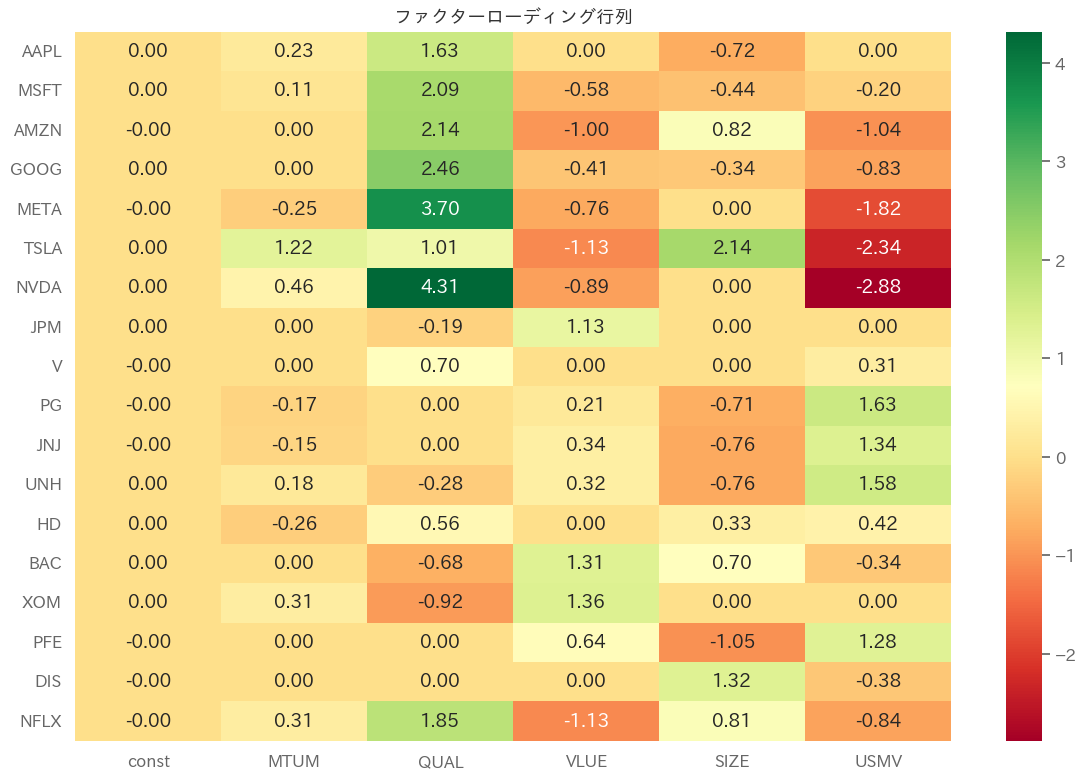


ファクター制約を設定中...

ファクター制約:
   Disabled Factor Sign  Value Relative Factor
0     False   MTUM   <=   -0.2                
1     False   QUAL   <=    0.8            USMV
2     False   SIZE   <=    0.4                
3     False   USMV   >=    0.6                
4     False   VLUE   <=    0.7                

戦略を初期化中...

ウェイトを計算中...
Optimization failed at index 60: Portfolio.optimization() got an unexpected keyword argument 'alpha'
Optimization failed at index 61: Portfolio.optimization() got an unexpected keyword argument 'alpha'
Optimization failed at index 62: Portfolio.optimization() got an unexpected keyword argument 'alpha'
Optimization failed at index 63: Portfolio.optimization() got an unexpected keyword argument 'alpha'
Optimization failed at index 64: Portfolio.optimization() got an unexpected keyword argument 'alpha'
Optimization failed at index 65: Portfolio.optimization() got an unexpected keyword argument 'alpha'
Optimization failed at index 66: Portfolio.optimization() got

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import riskfolio as rp
from quantechia.data.data_fetcher import FinancialDataFetcher

# 日付範囲の設定
start_date = '2021-01-01'
end_date = '2023-12-31'

# 資産のティッカー
assets = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'TSLA', 'NVDA', 'JPM', 
          'V', 'PG', 'JNJ', 'UNH', 'HD', 'BAC', 'XOM', 'PFE', 'DIS', 'NFLX']

# ファクターのティッカー（ETF）
factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']

# すべてのティッカーをリストに結合
all_tickers = assets + factors

# データを取得
print("データ取得中...")
fetcher = FinancialDataFetcher()
historical_data = fetcher.get_historical_data("yahoo", tickers=all_tickers, start=start_date, end=end_date)
data = historical_data['Close']

# 欠損値を前方補間で埋める
data = data.fillna(method='ffill')

# 資産価格とファクター価格を分割
price_data = data[assets]
factor_data = data[factors]

# データをリターンに変換
returns_data = price_data.pct_change().dropna()
factor_returns = factor_data.pct_change().dropna()



ローディング行列を計算中...

ローディング行列:
         const      MTUM      QUAL      VLUE      SIZE      USMV
AAPL  0.000198  0.233565  1.629983  0.000000 -0.718672  0.000000
MSFT  0.000392  0.109596  2.092606 -0.576180 -0.444326 -0.196852
AMZN -0.000372  0.000000  2.142399 -0.997459  0.824537 -1.044999
GOOG  0.000256  0.000000  2.463417 -0.405369 -0.337260 -0.834154
META -0.000009 -0.247638  3.702316 -0.759241  0.000000 -1.820508
TSLA  0.000472  1.224165  1.010720 -1.128429  2.137307 -2.335916
NVDA  0.001513  0.456739  4.311727 -0.886367  0.000000 -2.881690
JPM   0.000278  0.000000 -0.191522  1.134602  0.000000  0.000000
V    -0.000033  0.000000  0.699388  0.000000  0.000000  0.311382
PG   -0.000053 -0.170589  0.000000  0.209023 -0.712028  1.625659
JNJ  -0.000081 -0.151004  0.000000  0.341698 -0.758138  1.336458
UNH   0.000477  0.184881 -0.280783  0.324990 -0.762306  1.582708
HD    0.000099 -0.262645  0.564132  0.000000  0.332746  0.417643
BAC   0.000053  0.000000 -0.679440  1.310114  0.700879 -0.3363

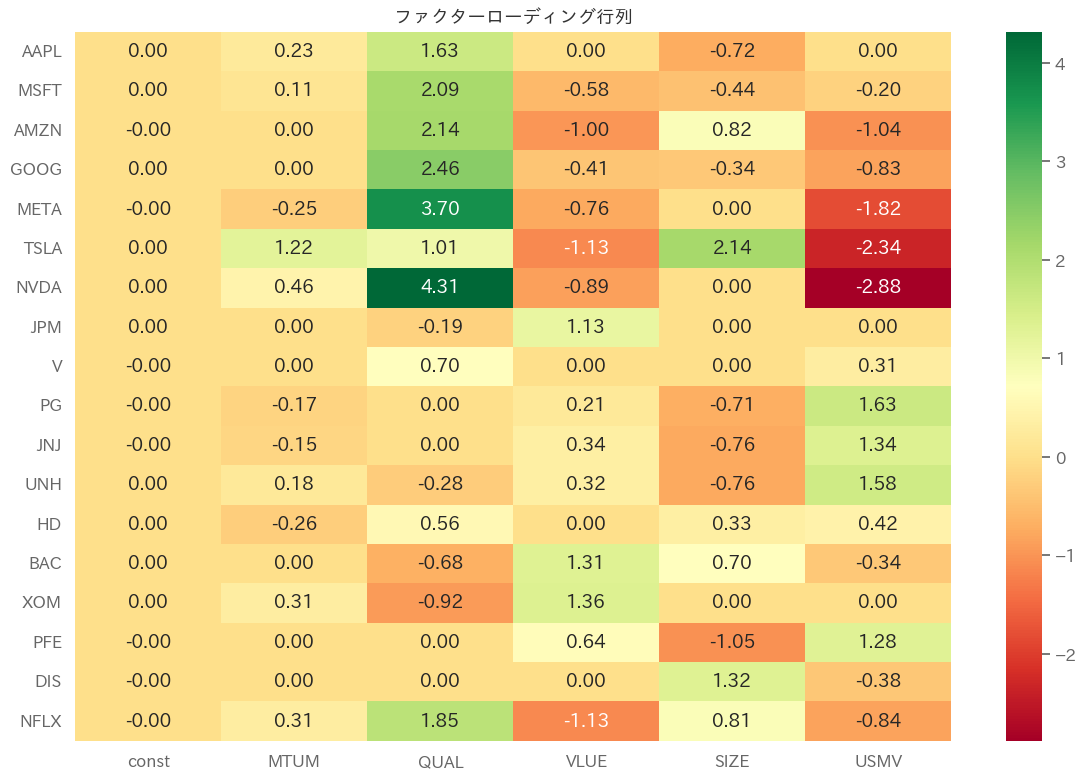


ファクター制約を設定中...

ファクター制約:
   Disabled Factor Sign  Value Relative Factor
0     False   MTUM   <=   -0.2                
1     False   QUAL   <=    0.8            USMV
2     False   SIZE   <=    0.4                
3     False   USMV   >=    0.6                
4     False   VLUE   <=    0.7                

戦略を初期化中...
The problem doesn't have a solution with actual input parameters
Optimization failed at index 60: 'NoneType' object has no attribute 'values'
The problem doesn't have a solution with actual input parameters
Optimization failed at index 61: 'NoneType' object has no attribute 'values'
The problem doesn't have a solution with actual input parameters
Optimization failed at index 62: 'NoneType' object has no attribute 'values'
The problem doesn't have a solution with actual input parameters
Optimization failed at index 63: 'NoneType' object has no attribute 'values'
The problem doesn't have a solution with actual input parameters
Optimization failed at index 64: 'NoneType' obj

KeyboardInterrupt: 

In [47]:

# ローディング行列の計算（全期間データを使用）
print("\nローディング行列を計算中...")
loadings = rp.loadings_matrix(X=factor_returns, Y=returns_data, stepwise='Forward')

print("\nローディング行列:")
print(loadings)

# ヒートマップとして視覚化
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='RdYlGn', annot=True, fmt=".2f")
plt.title('ファクターローディング行列')
plt.tight_layout()
plt.show()

# ファクター制約の設定
print("\nファクター制約を設定中...")
constraints = pd.DataFrame({
    'Disabled': [False, False, False, False, False],
    'Factor': ['MTUM', 'QUAL', 'SIZE', 'USMV', 'VLUE'],
    'Sign': ['<=', '<=', '<=', '>=', '<='],
    'Value': [-0.2, 0.8, 0.4, 0.6, 0.7],
    'Relative Factor': ['', 'USMV', '', '', '']
})

print("\nファクター制約:")
print(constraints)

# 最適化パラメータの設定
opt_params = {
    'model': 'FM',  # ファクターモデル
    'method_mu': 'hist',  # 期待リターンの推定方法
    'method_cov': 'hist',  # 共分散行列の推定方法
    'portfolio_args': {},  # ポートフォリオ作成時の引数
    'preprocessing_params': {
        'assets_stats': {
            'method_mu': 'hist',
            'method_cov': 'hist'
        },
        'factors_stats': {
            'method_mu': 'hist',
            'method_cov': 'hist'
        }
    },
    'optimize_params': {
        'rm': 'MV',       # リスク指標（分散）
        'obj': 'Sharpe',  # 目的関数（シャープレシオ最大化）
        
    }
}

# 戦略の初期化
print("\n戦略を初期化中...")
strategy = FactorConstrainedStrategy(
    price_data=price_data,
    factor_data=factor_data,
    lookback=60,  # 60営業日のルックバック期間
    optimizer='optimization',
    strategy_name='Factor Constrained Strategy',
    opt_params=opt_params,
    factor_constraints=constraints,
    stepwise='Forward'
)
strategy.evaluate()